In [114]:
!pip install extinction
# remove if duplicate
import pandas as pd
import numpy as np
import os
import glob
from extinction import fitzpatrick99
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
DATA_DIR = "mallorn-challenge/"
WAVELENGTHS = {'u': 3641, 'g': 4704, 'r': 6155, 'i': 7504, 'z': 8695, 'y': 10056}
log_df = pd.read_csv(os.path.join(DATA_DIR, "train_log.csv"))
print(log_df.head(), log_df.shape)

                  object_id       Z  Z_err    EBV SpecType  \
0  Dornhoth_fervain_onodrim  3.0490    NaN  0.110      AGN   
1       Dornhoth_galadh_ylf  0.4324    NaN  0.058    SN II   
2      Elrim_melethril_thul  0.4673    NaN  0.577      AGN   
3        Ithil_tobas_rodwen  0.6946    NaN  0.012      AGN   
4       Mirion_adar_Druadan  0.4161    NaN  0.058      AGN   

                               English Translation     split  target  
0  Trawn Folk (Dwarfs) + northern + Ents (people)   split_01       0  
1    Trawn Folk (Dwarfs) + tree + drinking vessel   split_01       0  
2                  Elves +  lover (fem.)  + breath  split_01       0  
3                    moon +  roof  +  noble maiden  split_01       0  
4            jewel, Silmaril  + father + Wild Man   split_01       0   (3043, 8)


Amount of duplicate object_id: 0

Amount of missing values (NA) in each column:
object_id                 0
Z                         0
Z_err                  3043
EBV                       0
SpecType                  0
English Translation       0
split                     0
target                    0
dtype: int64


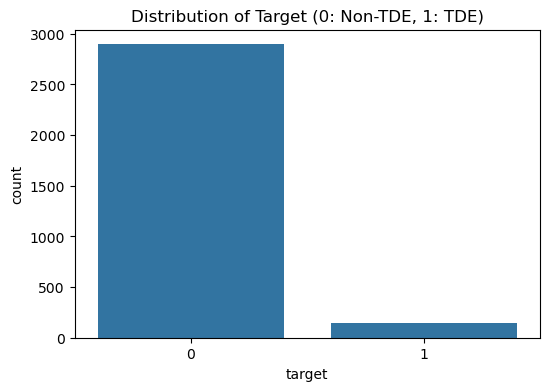

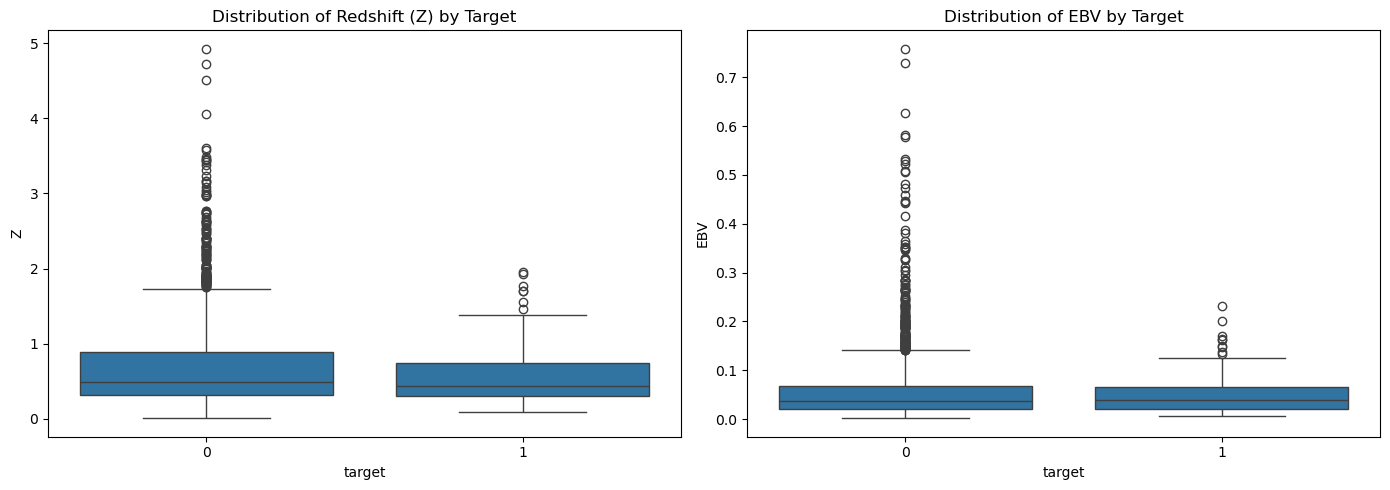

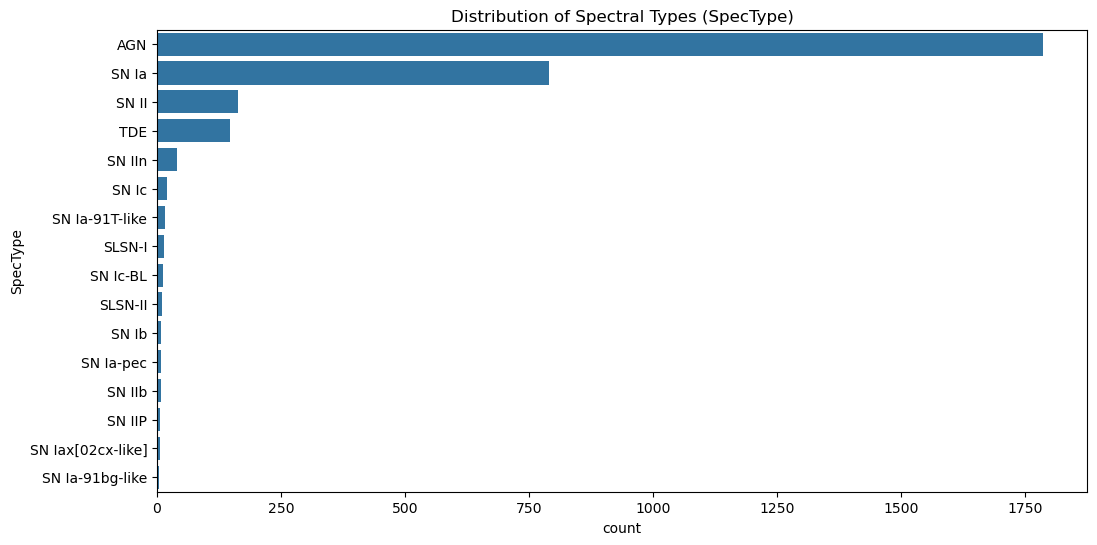

In [116]:
# 2.1. Check data quality (EDA Metadata)

# 1. Check duplicate object_id
n_duplicates = log_df['object_id'].duplicated().sum()
print(f"Amount of duplicate object_id: {n_duplicates}")

# 2. Count NA in each column
print("\nAmount of missing values (NA) in each column:")
print(log_df.isna().sum())

# 3. View target distribution (Class Imbalance)
plt.figure(figsize=(6, 4))
sns.countplot(data=log_df, x='target')
plt.title("Distribution of Target (0: Non-TDE, 1: TDE)")
plt.show()

# 4. Histogram / Boxplot of Z, EBV by target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Redshift (Z)
sns.boxplot(data=log_df, x='target', y='Z', ax=axes[0])
axes[0].set_title("Distribution of Redshift (Z) by Target")

# EBV
sns.boxplot(data=log_df, x='target', y='EBV', ax=axes[1])
axes[1].set_title("Distribution of EBV by Target")

plt.tight_layout()
plt.show()

# 5. Distribution of SpecType (if available)
if 'SpecType' in log_df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=log_df, y='SpecType', order=log_df['SpecType'].value_counts().index)
    plt.title("Distribution of Spectral Types (SpecType)")
    plt.show()
else:
    print("\nSpecType column not found in the data.")

**1. Some feedback personality here**
Non-TDE(target=0)≈2900
TDE(target=1)≈100-150
-> Imply this is imbalanced data problem--> consider use over sampling or under sampling techniques
-> if use model normally ML-> always predict non-TDE, high accuracy but useless model
-> apply 
- class weight in model training
- focal loss function
- oversampling techniques like SMOTE
- anomaly detection models

**2. RedShift**(Z) follow target"
Observed that Medians of botth class are similar
IQR(Interquartile Range) is quite stack together
non-TDE have many outliers(2-5), TDE have few outliers(0-1)
Conclusion:
Z is not strong feature to distinguish TDE and non-TDE
But Non-TDE have many objects in high redshift
TDE have redshift less than 1
-> secondary feature

**3. EBV dust extinction**
Median same 90%
Non-TDE have many outlier EBV (>=0.4-0.8)
EBV is not enough to distinct TDE


In [117]:
def process_flux(df):
    eps = 1e-6
    flux_err_safe = df['Flux_err'].replace(0, np.nan)
    denom = np.power(flux_err_safe, 2) + eps
    flux_ratio_sq = np.power(df['Flux'], 2) / denom
    df_flux = pd.DataFrame({
        'flux_ratio_sq': flux_ratio_sq,
        'flux_by_flux_ratio_sq': df['Flux'] * flux_ratio_sq
    }, index=df.index)
    return pd.concat([df, df_flux], axis=1)


In [118]:
def apply_de_extinction(df):
    wl_values = df['Filter'].map(WAVELENGTHS)
    ebv_values = df['EBV'].astype(float)

    a_lambda = np.full(len(df), np.nan)
    
    valid = ~wl_values.isna()

    if valid.any():
        unit_extinction = fitzpatrick99(wl_values[valid].values.astype(float), 1.0)
        a_lambda[valid] = unit_extinction * (ebv_values[valid] * 3.1)
    
    df['Flux_Real'] = df['Flux'] * (10 ** (a_lambda / 2.5))
    return df


In [ ]:
def process_data_pipeline(log_df, is_train=True):
    file_name = "train_full_lightcurves.csv" if is_train else "test_full_lightcurves.csv"
    cols_to_use = ['object_id', 'EBV', 'Z']
    if is_train:
        cols_to_use.append('target')
    log_lookup = log_df[cols_to_use]
    all_features = []
    for i in range(1, 21):
        split_path = os.path.join(DATA_DIR, f"Split_{i:02d}", file_name)
        if os.path.exists(split_path):
            print(f"Processing {split_path}...")
            chunk_df = pd.read_csv(split_path)
            chunk_df = chunk_df.merge(log_lookup[['object_id', 'EBV', 'Z']], on='object_id', how='left')
            chunk_df = apply_de_extinction(chunk_df)
            chunk_df = process_flux(chunk_df)

            agg_dict = {
                'Flux_Real': ['max', 'mean', 'min', 'std', 'median'],
                'Time (MJD)': ['min', 'max'],
                "Flux_err": ["mean"],
                'flux_ratio_sq': ['max', 'mean', 'min', 'std'],
                'flux_by_flux_ratio_sq': ['max', 'mean', 'min', 'std']
            }
            chunk_df["w"] = 1.0 / (chunk_df["Flux_err"]**2 + 1e-9)
            chunk_df["flux_w"] = chunk_df["Flux"] * chunk_df["w"]

            features = chunk_df.groupby(['object_id', 'Filter']).agg(agg_dict)
            features = features.unstack()
            features.columns = ['_'.join(map(str, col)).strip() for col in features.columns.values]
            features = features.reset_index()
            features = features.merge(log_lookup[['object_id', 'Z']], on='object_id', how='left')
            features['is_galactic'] = (features['Z'] < 0.005).astype(int)
            features['Log_Z'] = np.log1p(features['Z'])

            # Helper to safely aggregate across filters
            def safe_stat(prefix, func, fill=np.nan):
                cols = [c for c in features.columns if c.startswith(prefix)]
                if len(cols) == 0:
                    return pd.Series(fill, index=features.index)
                return func(features[cols], axis=1)

            flux_max = safe_stat('Flux_Real_max_', np.nanmax)
            flux_min = safe_stat('Flux_Real_min_', np.nanmin)
            flux_mean = safe_stat('Flux_Real_mean_', np.nanmean)
            flux_std = safe_stat('Flux_Real_std_', np.nanmean)
            flux_median = safe_stat('Flux_Real_median_', np.nanmedian)
            time_max = safe_stat('Time (MJD)_max_', np.nanmax)
            time_min = safe_stat('Time (MJD)_min_', np.nanmin)

            features["flux_amp"] = flux_max - flux_min
            features["flux_rel_amp"] = features["flux_amp"]/(flux_mean+1e-9)
            features["time_span"] = time_max - time_min
            features["slope"] = (flux_max - flux_min) / (time_max - time_min + 1e-9)
            features["peak_sharpness"] = (flux_max - flux_mean) / (flux_std + 1e-9)
            features["asymmetry"] = (flux_mean - flux_median) / (flux_std + 1e-9)

            if 'Flux_Real_max_g' in features.columns and 'Flux_Real_max_r' in features.columns:
                features['color_g_r'] = features['Flux_Real_max_g'] - features['Flux_Real_max_r']
            else:
                features['color_g_r'] = np.nan
            if 'Flux_Real_max_u' in features.columns and 'Flux_Real_max_g' in features.columns:
                features['color_u_g'] = features['Flux_Real_max_u'] - features['Flux_Real_max_g']
            else:
                features['color_u_g'] = np.nan
            if 'Time (MJD)_min_g' in fefatures.columns and 'Time (MJD)_min_g' in features.columns:
                duration_obs = features['Time (MJD)_max_g'] - features['Time (MJD)_min_g']
                features['duration_rest'] = duration_obs / (1 + features['Z'])
                features['duration_rest'] = features['duration_rest'].fillna(0)
            else:
                features['duration_rest'] = np.nan
            all_features.append(features)
            del chunk_df
    if len(all_features) > 0:
        final_df = pd.concat(all_features, ignore_index=True)
        if is_train:
            final_df = final_df.merge(log_lookup[['object_id', 'target']], on='object_id', how='left')
        return final_df
    else:
        print("No data files found.")
        return None


In [120]:
# Step 1 Read file log
print(" Reading doc files log...")
train_log = pd.read_csv(os.path.join(DATA_DIR, "train_log.csv"))
# Step 2 Call function process_data_pipeline to process data
print(" Processing training data...")
final_df = process_data_pipeline(train_log, is_train=True)
# Step 3 Check conclusions
if final_df is not None:
    print(" Final training data shape:", final_df.shape)
else:
    print(" Data processing failed.")


 Reading doc files log...
 Processing training data...
Processing mallorn-challenge/Split_01\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_02\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_03\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_04\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_05\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_06\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_07\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_08\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_09\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_10\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_11\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_12\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_13\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_14\train_full_lightcurves.

In [121]:
final_df.head(5)
test_df = final_df
test_df.to_csv('du_lieu.csv', index=False, encoding='utf-8-sig')
final_df.shape

(3043, 110)

In [122]:
# 1. Keep origin X_full_raw (LightGBM likes raw data)
X_final = final_df.drop(columns=['object_id', 'target'])

# Instead of 0.8 (80%), Let use 1.0 (100%) or 0.99
cols_to_drop = [col for col in X_final.columns if X_final[col].isnull().all()]
# if len(cols_to_drop) > 0:
#     print(f"Removing columns that are 100% empty: {cols_to_drop}")
#     X_final = X_final.drop(columns=cols_to_drop)

print("Data prepared for LightGBM (Keeping Outliers and NaN).")

Data prepared for LightGBM (Keeping Outliers and NaN).


In [123]:
clean_df = final_df 
clean_df.to_csv('du_lieu_clean.csv', index=False, encoding='utf-8-sig')
final_df.head(5)

,object_id,Flux_Real_max_g,Flux_Real_max_i,Flux_Real_max_r,Flux_Real_max_u,Flux_Real_max_y,Flux_Real_max_z,Flux_Real_mean_g,Flux_Real_mean_i,Flux_Real_mean_r,...,flux_amp,flux_rel_amp,time_span,slope,peak_sharpness,asymmetry,color_g_r,color_u_g,duration_rest,target
0,Dornhoth_fervain_onodrim,1.443179,27.844443,13.652524,4.248857,6.595811,29.125484,-0.548632,2.561695,1.397209,...,32.224557,35.942499,1254.2719,0.025692,6.404141,0.355453,-12.209345,2.805678,171.733934,0
1,Dornhoth_galadh_ylf,1.529061,5.750219,3.010044,1.366717,12.100761,7.828148,0.220424,0.391522,0.315478,...,13.959230,36.674420,2362.1560,0.005910,9.671311,0.235265,-1.480982,-0.162344,1598.899958,0
2,Elrim_melethril_thul,9.323011,13.610121,10.907899,4.584901,11.958579,14.600198,4.030563,7.175760,5.157701,...,26.437946,6.257803,1206.0218,0.021922,1.547238,0.215287,-1.584888,-4.738110,340.008110,0
3,Ithil_tobas_rodwen,1.427632,2.265997,1.919788,1.694542,5.422723,3.035932,0.290364,0.455225,0.447510,...,13.162889,35.226735,2858.4129,0.004605,6.645717,-0.035836,-0.492155,0.266910,1681.706892,0
4,Mirion_adar_Druadan,1.811562,5.962067,2.694332,0.683562,2.521655,2.925379,0.056517,0.425128,0.240721,...,9.217586,41.535894,2202.3065,0.004185,4.740169,-0.166861,-0.882771,-1.127999,1542.712450,0


In [124]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE
import numpy as np
import lightgbm as lgb

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_jobs': -1,  # use all CPU cores

        # 1. Key parameters to tune
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),

        # 2. Regularization to prevent overfitting
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    for train_idx, val_idx in kf.split(X, y):
        X_train, y_train = X.iloc[train_idx], y[train_idx]
        X_val, y_val = X.iloc[val_idx], y[val_idx]

        # Fill zeros for SMOTE compatibility
        X_train_filled = X_train.fillna(0)
        X_val_filled = X_val.fillna(0)

        # Dynamic k_neighbors to avoid failures on tiny minority folds
        minority_count = int((y_train == 1).sum())
        if minority_count > 1:
            k_neighbors = max(1, min(5, minority_count - 1))
            smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
            X_train_res, y_train_res = smote.fit_resample(X_train_filled, y_train)
        else:
            X_train_res, y_train_res = X_train_filled, y_train

        model = lgb.LGBMClassifier(**param)
        callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]
        model.fit(X_train_res, y_train_res, eval_set=[(X_val_filled, y_val)], callbacks=callbacks)

        probs = model.predict_proba(X_val_filled)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_val, probs)
        f1s = 2 * recall * precision / (recall + precision + 1e-9)
        if len(thresholds) == 0:
            best_f1_fold = 0.0
        else:
            best_f1_fold = np.nanmax(f1s[:-1])
        f1_scores.append(best_f1_fold)

    return float(np.mean(f1_scores))

In [125]:
from optuna.samplers import TPESampler 
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
print("⏳ Running Optuna")
# n_trials=50 is a reasonable number. If you have time, set it to 100.
study.optimize(objective, n_trials=50)

print("\n" + "="*30)
print("🏆 BEST RESULTS:")
print(f"Best F1-Score: {study.best_value:.4f}")
print("Best Hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-12-12 14:25:54,262] A new study created in memory with name: no-name-2905f7e5-fafc-4e1b-8d61-20662888d982


⏳ Running Optuna


[I 2025-12-12 14:26:00,862] Trial 0 finished with value: 0.41101183509397315 and parameters: {'learning_rate': 0.019906996673933378, 'n_estimators': 1927, 'num_leaves': 225, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.41101183509397315.
[I 2025-12-12 14:26:03,464] Trial 1 finished with value: 0.390725385948394 and parameters: {'learning_rate': 0.06813099824138592, 'n_estimators': 530, 'num_leaves': 292, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 0 with value: 0.41101183509397315.
[I 2025-12-12 14:26:06,421] Trial 2 finished with value: 0.38383137279969926 and parameters: {'learning_rate': 0.02460208061014162, 'n_estimators': 937, 'num_leaves': 191, 'max_depth': 4,


🏆 BEST RESULTS:
Best F1-Score: 0.4245
Best Hyperparameters:
  learning_rate: 0.03915406382436702
  n_estimators: 657
  num_leaves: 208
  max_depth: 8
  min_child_samples: 16
  subsample: 0.6191553880356218
  colsample_bytree: 0.8461207343276633
  reg_alpha: 0.4528604759180585
  reg_lambda: 0.022823590255140806


✅ Found Optuna results. Loading best parameters...
--------------------------------------------------
Current Params: {'learning_rate': 0.03915406382436702, 'n_estimators': 657, 'num_leaves': 208, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.6191553880356218, 'colsample_bytree': 0.8461207343276633, 'reg_alpha': 0.4528604759180585, 'reg_lambda': 0.022823590255140806, 'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'random_state': 42, 'n_jobs': -1}
--------------------------------------------------
🚀 Starting LightGBM Training with Best Params + SMOTE...
   Fold 1 Finished. F1 (0.5 threshold): 0.3438
   Fold 2 Finished. F1 (0.5 threshold): 0.3607
   Fold 3 Finished. F1 (0.5 threshold): 0.3438
   Fold 4 Finished. F1 (0.5 threshold): 0.3944
   Fold 5 Finished. F1 (0.5 threshold): 0.3226

🎯 Finding the best threshold on the entire OOF set...
✅ Best Threshold: 0.3816
✅ Best F1-Score (at that threshold): 0.3869

🏆 FINAL RESULTS (TRAIN):
              precision  

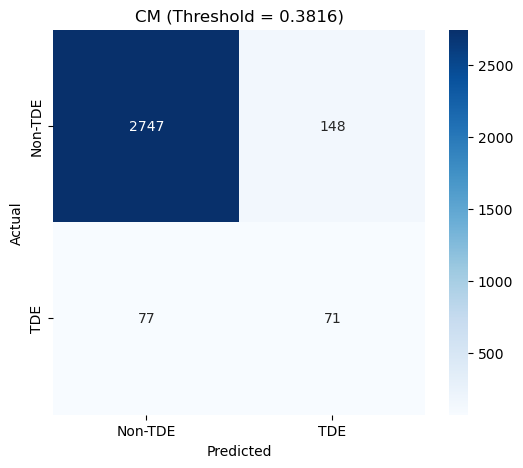

In [126]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. PREPARATION ---
X = final_df.drop(columns=['object_id', 'target'])
y = final_df['target'].values
object_ids = final_df['object_id'].values

# --- 2. SETUP PARAMETERS (BEST PARAMS) ---
if 'study' in globals():
    print("✅ Found Optuna results. Loading best parameters...")
    best_params = study.best_params
    best_params.update({
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'random_state': 42,
        'n_jobs': -1
    })
else:
    print("⚠️ Optuna not run yet. Using manual baseline parameters...")
    best_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'random_state': 42,
        'n_jobs': -1,
        'n_estimators': 1500,
        'learning_rate': 0.03,
        'num_leaves': 31,
        'max_depth': -1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
    }

# Add class weight to address imbalance (safe even with SMOTE)
# pos_weight = (len(y) - y.sum()) / max(y.sum(), 1e-9)
# best_params.setdefault('scale_pos_weight', float(pos_weight))

print("-" * 50)
print("Current Params:", best_params)
print("-" * 50)

# --- 3. TRAINING LOOP (OFFICIAL PIPELINE) ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_preds_proba = np.zeros(len(final_df))
models = []

print("🚀 Starting LightGBM Training with Best Params + SMOTE...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_val, y_val = X.iloc[val_idx], y[val_idx]

    # Fill NaN with 0 for SMOTE compatibility (keep consistent for val)
    X_train_filled = X_train.fillna(0)
    X_val_filled = X_val.fillna(0)

    # Dynamic SMOTE to avoid minority-fold crashes
    minority_count = int((y_train == 1).sum())
    if minority_count > 1:
        k_neighbors = max(1, min(5, minority_count - 1))
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_filled, y_train)
    else:
        X_train_resampled, y_train_resampled = X_train_filled, y_train

    model = lgb.LGBMClassifier(**best_params)
    callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=False), lgb.log_evaluation(period=0)]
    model.fit(
        X_train_resampled, y_train_resampled,
        eval_set=[(X_val_filled, y_val)],
        eval_metric='binary_logloss',
        callbacks=callbacks
    )

    models.append(model)

    val_preds_proba = model.predict_proba(X_val_filled)[:, 1]
    oof_preds_proba[val_idx] = val_preds_proba

    temp_score = f1_score(y_val, (val_preds_proba >= 0.5).astype(int))
    print(f"   Fold {fold+1} Finished. F1 (0.5 threshold): {temp_score:.4f}")

# --- 4. THRESHOLD TUNING ---
print("\n🎯 Finding the best threshold on the entire OOF set...")

precision, recall, thresholds = precision_recall_curve(y, oof_preds_proba)
f1_scores = 2 * recall * precision / (recall + precision + 1e-9)
if len(thresholds) == 0:
    best_threshold = 0.5
    best_f1 = 0.0
else:
    best_idx = np.nanargmax(f1_scores[:-1])
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[:-1][best_idx]

print(f"✅ Best Threshold: {best_threshold:.4f}")
print(f"✅ Best F1-Score (at that threshold): {best_f1:.4f}")

# --- 5. FINAL EVALUATION ---
final_preds = (oof_preds_proba >= best_threshold).astype(int)

print("\n" + "="*30)
print("🏆 FINAL RESULTS (TRAIN):")
print(classification_report(y, final_preds, target_names=['Non-TDE', 'TDE']))

cm = confusion_matrix(y, final_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-TDE', 'TDE'], yticklabels=['Non-TDE', 'TDE'])
plt.title(f'CM (Threshold = {best_threshold:.4f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [127]:
import enum
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, f1_score, average_precision_score
from sympy import oo

precision, recall, thresholds = precision_recall_curve(y, oof_preds_proba)
f1_scores = 2 * recall * precision / (recall + precision + 1e-9)

if len(thresholds) == 0:
    best_threshold = 0.5
    print("precision_recall_curve returned empty thresholds; defaulting threshold to 0.5")
else:
    best_index = np.nanargmax(f1_scores[:-1])  # f1_scores length = len(thresholds)+1
    best_threshold = thresholds[best_index]

pr_auc = average_precision_score(y, oof_preds_proba)
print(f"OFF best F1={np.nanmax(f1_scores):.4f} at threshold={best_threshold:.4f}, PR AUC={pr_auc:.4f}")

fold_threshold, fold_f1_scores = [], []
for fold_index, (train_idx, val_idx) in enumerate(kf.split(final_df, y)):
    p = oof_preds_proba[val_idx]
    yv = y[val_idx]
    precision_v, recall_v, thresholds_v = precision_recall_curve(yv, p)
    f1_v = 2 * recall_v * precision_v / (recall_v + precision_v + 1e-9)
    if len(thresholds_v) > 0:
        j = np.nanargmax(f1_v[:-1])
        fold_threshold.append(thresholds_v[j])
        fold_f1_scores.append(f1_v[j])
        print(f"  - Fold {fold_index+1}: Best F1={f1_v[j]:.4f} at threshold={thresholds_v[j]:.4f}")
    else:
        print(f"  - Fold {fold_index+1}: precision_recall_curve returned empty thresholds")

if len(fold_threshold) > 0:
    print("Threshold stability: mean={:.4f}, std={:.4f}, IQR=({:.4f},{:.4f})"
          .format(np.mean(fold_threshold), np.std(fold_threshold),
                  np.percentile(fold_threshold, 25), np.percentile(fold_threshold, 75)))
else:
    print("Threshold stability: fold_threshold is empty; check data/PR curve output")

rng = np.random.default_rng(42)
boot_thrs = []
for _ in range(200):
    idx = rng.integers(0, len(oof_preds_proba), len(oof_preds_proba))
    pb = oof_preds_proba[idx]; yb = y[idx]
    prec_b, rec_b, thr_b = precision_recall_curve(yb, pb)
    f1_b = 2 * (prec_b * rec_b) / (prec_b + rec_b + 1e-9)
    if len(thr_b) > 0:
        boot_thrs.append(thr_b[np.nanargmax(f1_b[:-1])])
if len(boot_thrs) > 0:
    print("Bootstrap threshold CI ~ [{:.4f}, {:.4f}]"
          .format(np.percentile(boot_thrs, 2.5), np.percentile(boot_thrs, 97.5)))
else:
    print("Bootstrap threshold CI not computed (empty thr_b)")

OFF best F1=0.3869 at threshold=0.3816, PR AUC=0.2988
  - Fold 1: Best F1=0.3684 at threshold=0.3816
  - Fold 2: Best F1=0.4646 at threshold=0.1425
  - Fold 3: Best F1=0.3889 at threshold=0.3850
  - Fold 4: Best F1=0.4815 at threshold=0.7676
  - Fold 5: Best F1=0.4516 at threshold=0.1924
Threshold stability: mean=0.3738, std=0.2198, IQR=(0.1924,0.3850)
Bootstrap threshold CI ~ [0.0953, 0.4776]


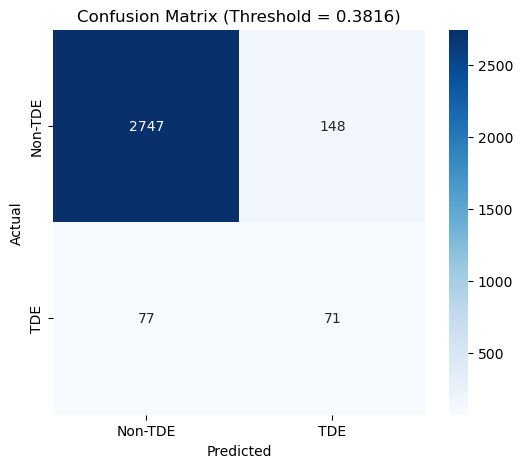

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22380\1707946897.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature",


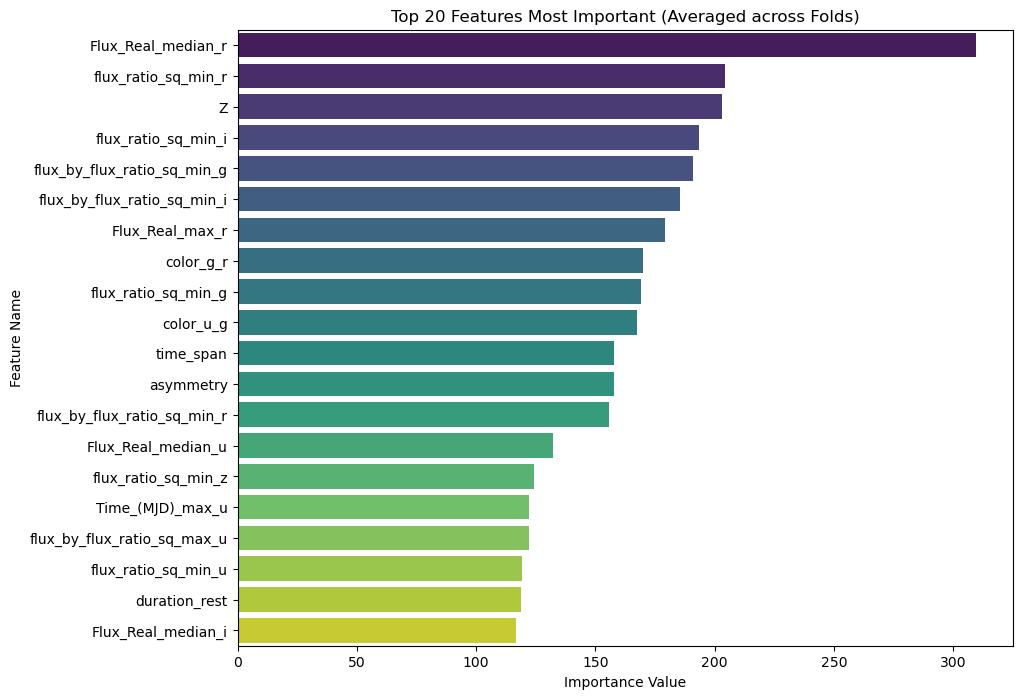

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- PHẦN 1: CONFUSION MATRIX () ---
final_preds = (oof_preds_proba >= best_threshold).astype(int)
cm = confusion_matrix(y, final_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-TDE', 'TDE'], yticklabels=['Non-TDE', 'TDE'])
plt.title(f'Confusion Matrix (Threshold = {best_threshold:.4f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# --- PHẦN 2: FEATURE IMPORTANCE (Fix prevent fail column) ---
if len(models) > 0:
    imp_list = []
    
    for i, model in enumerate(models):
        # 1. Lấy tên feature chuẩn từ chính model đó (để tránh lệch số lượng)
        # LightGBM sklearn API lưu tên ở .feature_name_
        try:
            feat_names = model.feature_name_
        except AttributeError:
            # Fallback nếu model không có attribute đó (dùng booster)
            feat_names = model.booster_.feature_name()
            
        # 2. Lấy độ quan trọng
        feat_imps = model.feature_importances_
        
        # 3. Tạo DataFrame tạm
        imp_df = pd.DataFrame({
            'Feature': feat_names,
            'Importance': feat_imps
        })
        imp_list.append(imp_df)

    # 4. Gộp và tính trung bình
    full_imp_df = pd.concat(imp_list, ignore_index=True)
    avg_feature_imp = full_imp_df.groupby('Feature')['Importance'].mean().reset_index()

    # 5. Vẽ biểu đồ
    plt.figure(figsize=(10, 8))
    sns.barplot(x="Importance", y="Feature", 
                data=avg_feature_imp.sort_values(by="Importance", ascending=False).head(20),
                palette="viridis")
    plt.title('Top 20 Features Most Important (Averaged across Folds)')
    plt.xlabel('Importance Value')
    plt.ylabel('Feature Name')
    plt.show()
else:
    print("⚠️ Không tìm thấy model nào để vẽ Feature Importance.")

In [129]:
import pandas as pd
import numpy as np
import os

print("🚀 Bắt đầu tạo Submission (Inference)...")

# 1. Read input files
sample_sub = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))
test_log = pd.read_csv(os.path.join(DATA_DIR, "test_log.csv"))

# 2. Feature Engineering
# Call the pipeline function you wrote
# NOTE: If RAM is weak, this part may crash. If it crashes, let me know to use Chunking code (Part 4).
test_df = process_data_pipeline(test_log, is_train=False)

# 3. Column Alignment - Very Important!
# We must ensure the order and number of columns in Test EXACTLY match those in Train
# Get the list of columns from the Train set (X)
train_features = X.columns.tolist() 

# 3.1. Add missing columns (if any) and fill with 0
missing_cols = set(train_features) - set(test_df.columns)
for c in missing_cols:
    test_df[c] = 0

# 3.2. Keep only the columns used for Training (in the correct order)
# (This step automatically removes extra columns like 'object_id' from X_test)
X_test = test_df[train_features]

# 4. Minimal Preprocessing
# ABSOLUTELY NO CLIPPING, NO MEDIAN IMPUTATION
# Only fillna(0) to be consistent with when we trained SMOTE
X_test = X_test.fillna(0)

print(f"Test data is ready. Shape: {X_test.shape}")

# 5. Prediction (Ensemble Prediction)
# Take the average probability from 5 models (5 Folds)
test_probas = np.zeros(len(X_test))

for i, model in enumerate(models):
    print(f"Checking model {i+1}/{len(models)}...")
    # Accumulate probabilities
    test_probas += model.predict_proba(X_test)[:, 1]

# Average probabilities
test_probas /= len(models)

# 6. Apply Best Threshold
# best_threshold is the value you found in the previous Cross-Validation step
print(f"Applying threshold: {best_threshold:.4f}")
test_preds = (test_probas >= best_threshold).astype(int)

# 7. Write Submission file in the correct format
sub = sample_sub.copy()

# Ensure correct mapping of predictions to the correct object_id
# Create a dictionary {id: pred} for accurate mapping
pred_dict = dict(zip(test_df['object_id'], test_preds))

# Map to the sample file
sub['prediction'] = sub['object_id'].map(pred_dict).fillna(0).astype(int)

# Save file
sub.to_csv('submission.csv', index=False)
print('✅ Successfully saved submission.csv!')
print('Prediction statistics:')
print(sub['prediction'].value_counts())

🚀 Bắt đầu tạo Submission (Inference)...
Processing mallorn-challenge/Split_01\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_02\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_03\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_04\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_05\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_06\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_07\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_08\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_09\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_10\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_11\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_12\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_13\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_14\test_full_lightcurves.csv...
Processing mallorn-cha